In [30]:
import random
import numpy as np
import cv2

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torchvision.models import resnet50

from tqdm.notebook import tqdm, trange

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 4  # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

In [132]:
# Загрузим данные

train_dataset = SVHN(
    root='./SVHN/train',
    split='train', 
    transform=basic_transform,
    download=True
)

test_dataset = SVHN(
    root='./SVHN/test',
    split='test', 
    transform=transforms.ToTensor(),  # Для тестовых данные НЕ НАДО использовать нгикакие аугментации
    download=True
)

td = train_dataset

Using downloaded and verified file: ./SVHN/train\train_32x32.mat
Using downloaded and verified file: ./SVHN/test\test_32x32.mat


In [7]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [54]:
class SVHNClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(SVHNClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [9]:
model = SVHNClassifier(OUTPUT_DIM)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\tema/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [11]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.811, 0.711, 0.871), (0.429, 0.324, 0.425))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2777 Acc: 0.1770 

Epoch: 1. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2242 Acc: 0.2114 

Epoch: 2. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2360 Acc: 0.1950 

Epoch: 2. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2082 Acc: 0.2193 

Epoch: 3. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2264 Acc: 0.1966 

Epoch: 3. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.1999 Acc: 0.2235 

Epoch: 4. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2186 Acc: 0.2000 

Epoch: 4. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.1919 Acc: 0.2277 

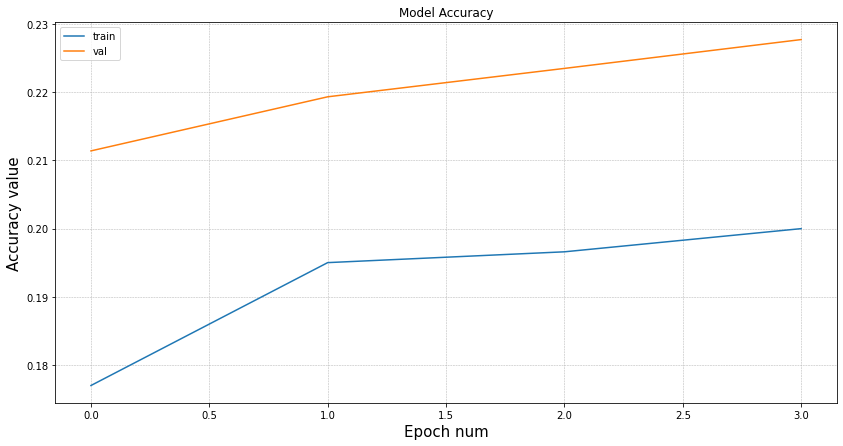

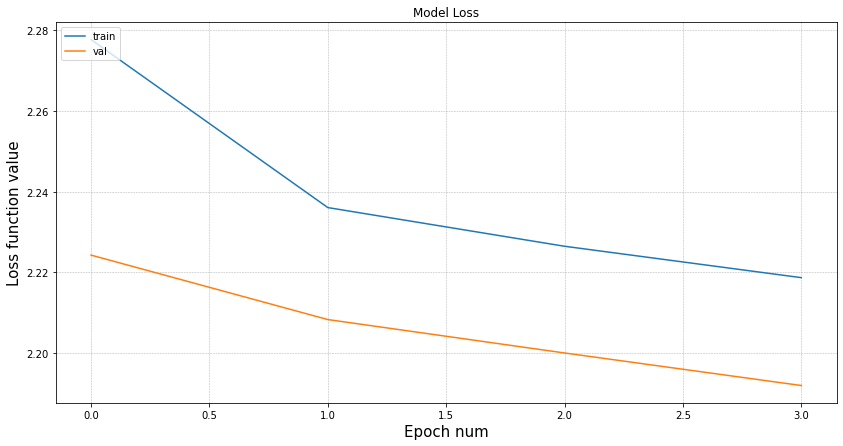

In [12]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

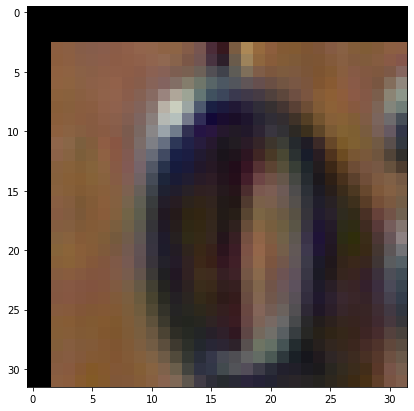

In [65]:
img = train_dataset[642][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [125]:
train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((2, 0, 0), (0.229, 0.224, 0.225), inplace=True)(xs)
xs.size()

torch.Size([1000, 3, 32, 32])

In [126]:
embs = model.embed(xs)
embs.size()

torch.Size([1000, 64])

In [117]:
import umap 

points = umap.UMAP().fit_transform(embs.detach().numpy())
points.shape

(1000, 2)

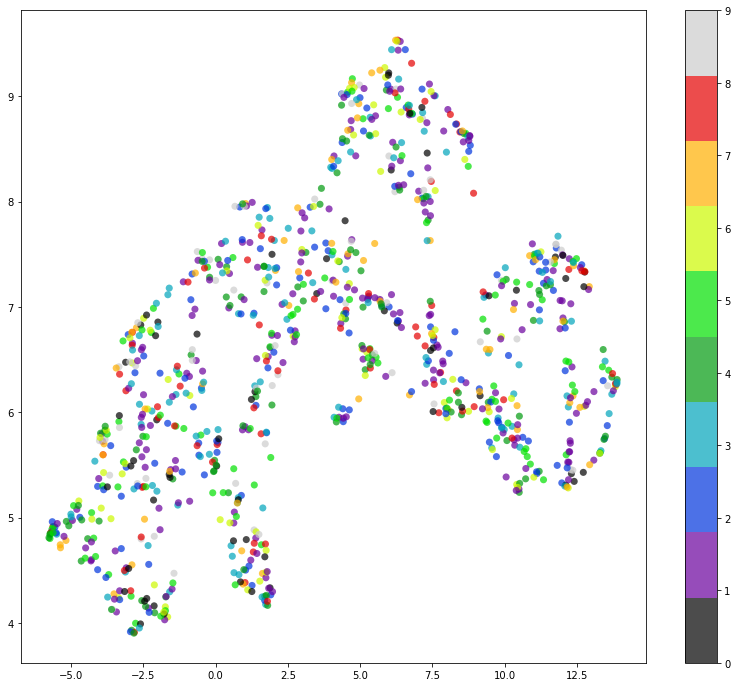

In [22]:
plt.figure(figsize=(14,12))
plt.scatter(points[:, 0], points[:, 1], c=ys, 
            edgecolor='none', alpha=0.7, s=50,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [143]:
titems = [td[i] for i in range(1000)]
xs, ys = zip(*titems)

xs = torch.stack(xs)
xs.size()

embs = model.embed(xs)
embs.size()

torch.Size([1000, 64])

In [144]:
from torch.utils.tensorboard import SummaryWriter
 
writer = SummaryWriter()

In [145]:
# log embeddings
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()

In [146]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [147]:
%tensorboard --logdir runs --bind_all

Reusing TensorBoard on port 6006 (pid 18280), started 15:34:15 ago. (Use '!kill 18280' to kill it.)

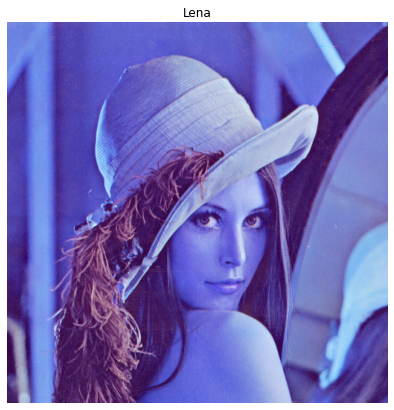

In [32]:
img = cv2.imread('lena.png')

plt.figure(figsize=(7,7))
plt.imshow(img)
plt.axis('off')
plt.title('Lena')
plt.show()

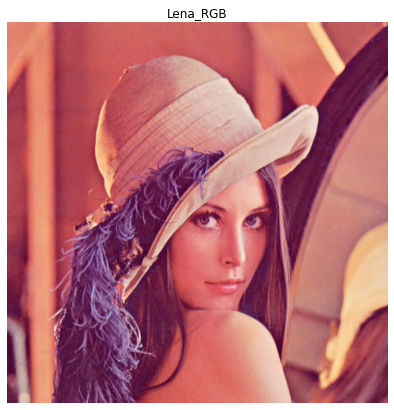

In [33]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(7,7))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Lena_RGB')
plt.show()

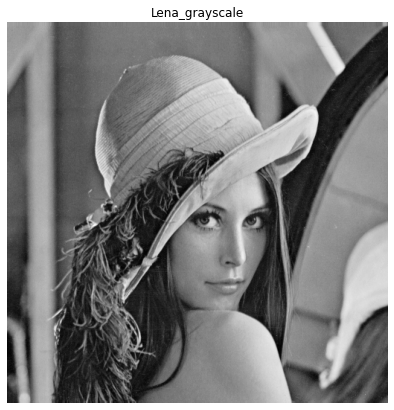

In [34]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(7,7))
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title('Lena_grayscale')
plt.show()

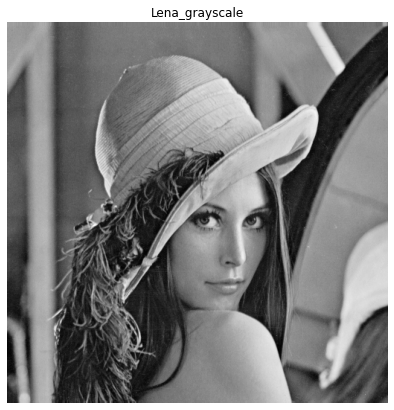

In [36]:
imgg = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(7,7))
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title('Lena_grayscale')
plt.show()

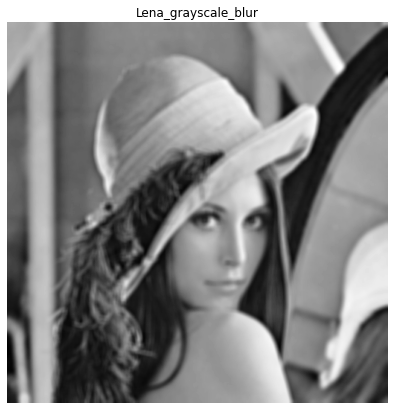

In [37]:
img_gray_copy = cv2.blur(imgg, ksize=(7, 7))

plt.figure(figsize=(7,7))
plt.imshow(img_gray_copy, cmap='gray')
plt.axis('off')
plt.title('Lena_grayscale_blur')
plt.show()

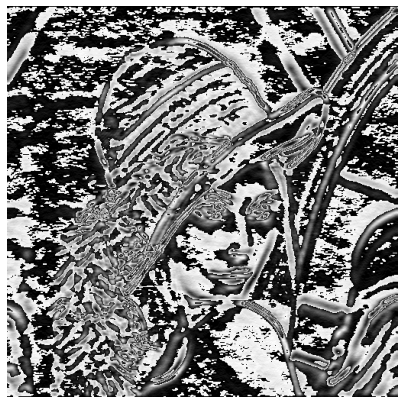

In [38]:
from scipy.ndimage import convolve

kernel = np.array([[3, 10, 3],[0, 0, 0],[-3, -10, -3]])

img_conv=convolve(img_gray_copy, kernel)
plt.figure(figsize=(7, 10))
plt.axis('off')
plt.imshow(img_conv, cmap='gray')

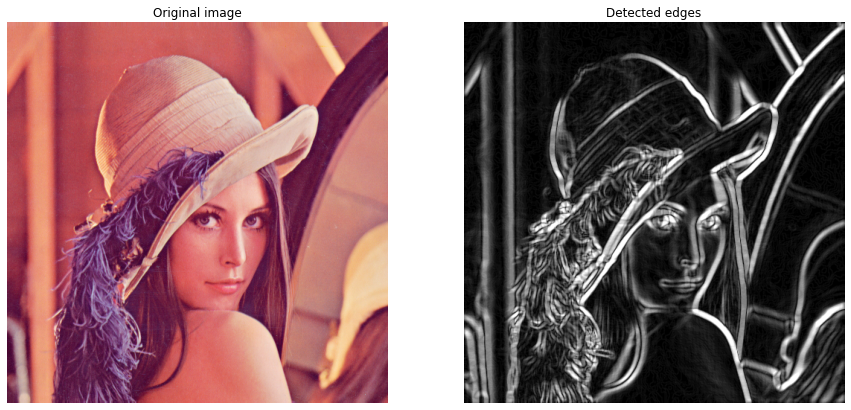

In [40]:
img_gray_copy = cv2.blur(imgg, ksize=(7, 7))

edges = cv2.addWeighted(
    cv2.convertScaleAbs(cv2.Scharr(img_gray_copy, cv2.CV_64F, 1, 0)),
    0.5,
    cv2.convertScaleAbs(cv2.Scharr(img_gray_copy, cv2.CV_64F, 0, 1)),
    0.5,
    0)

plt.figure(figsize=(15, 10))

ax = plt.subplot(121)
ax.set_title('Original image')
ax.axis('off')
ax.imshow(img_rgb)

ax = plt.subplot(122)
ax.set_title('Detected edges')
ax.axis('off')
ax.imshow(edges, cmap='gray');